In [1]:
#### run for customer clustering ####

# load the needed packages
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.colors import ListedColormap
from datetime import datetime

import seaborn as sns
import numpy as np

from sklearn.cluster import KMeans
from sklearn.feature_extraction import FeatureHasher
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler, RobustScaler, MaxAbsScaler
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
from scipy.spatial import distance

In [2]:
#### run for customer clustering ####

# read new dataset from AAG
df = pd.read_parquet('cleaned_data.parquet')

In [ ]:
# checks for empty quantity values

df.isnull().sum()

print(df["Quantity"].info())
print(df["NetRevenue"].info())
print(df["OrderNumber"].info())

df.sample(10)

In [ ]:
# Only keep rows in 2023?
df = df[df['OrderDate'].dt.year == 2023]
df.info()

In [3]:
# inspect dataset
df.head()

,OrderNumber,Company,ArticleID,OrderDate,CustomerID,RevenueType,PricePackagingUnit,Quantity,NetRevenue,ProductGroup,ProductSubgroup,BusinessArea,Type,PostalCode,IndustryGroup,SalesChannelCategory,SalesChannel,Season,State,City
0,SGR1300011,AAG,106155952,2023-02-07,147456,Serviceauftrag,0.248691,1.0,0.248691,ZUBEHÖR&ERSATZTEILE,ZUBEHÖR&ERSATZTEILE WA,WA,Artikel,79108,WKO,B2B2C_LV repairers,B2B2C,Spring,Baden-Württemberg,Freiburg im Breisgau
1,SGR1300063,AAG,108629180,2023-04-03,147828,Serviceauftrag,8.900524,1.0,8.900524,Projektkategorie,Projektkategorie,WA,Stunde,79189,SON,B2B_Industrial,B2B,Summer,Baden-Württemberg,Bad Krozingen
2,SGR1300011,AAG,108629180,2023-02-07,147456,Serviceauftrag,6.413613,1.0,6.413613,Projektkategorie,Projektkategorie,WA,Stunde,79108,WKO,B2B2C_LV repairers,B2B2C,Spring,Baden-Württemberg,Freiburg im Breisgau
3,SGR1300011,AAG,104537470,2023-02-07,147456,Serviceauftrag,2.591623,1.0,2.591623,ZUBEHÖR&ERSATZTEILE,ZUBEHÖR&ERSATZTEILE WA,WA,Artikel,79108,WKO,B2B2C_LV repairers,B2B2C,Spring,Baden-Württemberg,Freiburg im Breisgau
4,RG13000013981,AAG,105840646,2023-02-14,154024,Rechnung,5.003927,2.0,10.007853,BREMSE,BREMSSCHEIBEN,IAM,Artikel,79219,WCC,B2B2C_LV repairers,B2B2C,Spring,Baden-Württemberg,Staufen im Breisgau


## Preprocessing & Data Understanding

In [2]:
##### deprecated, not needed for current run #####

##### preprocessing to get final dataset with transformed values (cf. repo files) #####
#### ideally not needed with final preprocessing pipeline ####

#df = pd.read_parquet('Final.parquet')
#print(df.info())


# from initial repo file
# Convert SalesDate_SK to datetime
df['OrderDate'] = pd.to_datetime(df['OrderDate'], format='%Y%m%d')

# Add column for season
def season_from_month(month):
    if month in [12, 1, 2]:
        return 'Winter'
    elif month in [3, 4, 5]:
        return 'Spring'
    elif month in [6, 7, 8]:
        return 'Summer'
    elif month in [9, 10, 11]:
        return 'Autumn'
    else:
        return 'Unknown'
    
df['Season'] = df['OrderDate'].dt.month.apply(season_from_month)

# Only keep rows in 2023
df = df[df['OrderDate'].dt.year == 2023]

#print(df.head())
print(df.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13734196 entries, 0 to 18777102
Data columns (total 20 columns):
 #   Column                Dtype         
---  ------                -----         
 0   OrderNumber           object        
 1   Company               object        
 2   ArticleID             int64         
 3   OrderDate             datetime64[ns]
 4   CustomerID            object        
 5   RevenueType           object        
 6   PricePackagingUnit    float64       
 7   Quantity              float64       
 8   NetRevenue            float64       
 9   ProductGroup          object        
 10  ProductSubgroup       object        
 11  BusinessArea          object        
 12  Type                  object        
 13  PostalCode            object        
 14  IndustryGroup         object        
 15  SalesChannelCategory  object        
 16  SalesChannel          object        
 17  State                 object        
 18  City                  object        
 19

In [5]:
##### deprecated, not needed for current run #####

# create data sample for testing the code
# tbd run final code on total df

data_sample = df.sample(10000)

print(data_sample.head())
#data_sample[["PricePackagingUnit", "Quantity", "NetRevenue"]].describe()

            OrderNumber Company  ArticleID  OrderDate CustomerID RevenueType  \
18861145       92648053  HENNIG  102668016 2023-02-22    5338949    Rechnung   
17814111       92807991  HENNIG  106024312 2023-05-05   10037416  Gutschrift   
576347    RG13000139716     AAG  104313530 2023-12-20     146737    Rechnung   
17634485       92723975  HENNIG  111631182 2023-03-30    8956405  Gutschrift   
19974489       93103908  HENNIG  102596102 2023-10-02    5344701    Rechnung   

          PricePackagingUnit  Quantity  NetRevenue  \
18861145           17.801047       NaN   17.797120   
17814111            4.450262       NaN   -4.505236   
576347              4.814136       1.0    1.732984   
17634485            1.570681       NaN   -1.570681   
19974489            1.178010       NaN    1.178010   

                              ProductGroup                   ProductSubgroup  \
18861145                          ELEKTRIK                       GENERATOREN   
17814111                          

In [4]:
# inspect large quantities in entire dataset, don't seem to be outliers
df.loc[df['Quantity'] >= 3000]

,OrderNumber,Company,ArticleID,OrderDate,CustomerID,RevenueType,PricePackagingUnit,Quantity,NetRevenue,ProductGroup,ProductSubgroup,BusinessArea,Type,PostalCode,IndustryGroup,SalesChannelCategory,SalesChannel,State,City,Season
154832,RG13000030786,AAG,104695197,2023-03-07,150366,Rechnung,0.022251,6000.0,133.507853,UMWELT & ENTSORGUNG,UMWELT & ENTSORGUNG WA,WA,Artikel,79110,IND,B2B_Industrial,B2B,Baden-Württemberg,Freiburg im Breisgau,Spring
541770,RG13000110722,AAG,107071501,2023-09-18,155045,Rechnung,0.000000,3100.0,0.000000,PFAND,PFAND IAM,IAM,Service,79110,WKO,B2B2C_LV repairers,B2B2C,Baden-Württemberg,Freiburg im Breisgau,Autumn
569950,RG13000117545,AAG,103608592,2023-10-17,151540,Rechnung,0.451571,10080.0,4551.832461,CHEMIE,SERVICEPRODUKTE & SPRAYS,IAM,Artikel,48155,KOO,B2B_wholesalers,B2B,Nordrhein-Westfalen,Münster,Autumn
638067,RG13000122773,AAG,104695197,2023-10-20,150366,Rechnung,0.022251,6000.0,133.507853,UMWELT & ENTSORGUNG,UMWELT & ENTSORGUNG WA,WA,Artikel,79110,IND,B2B_Industrial,B2B,Baden-Württemberg,Freiburg im Breisgau,Autumn
2711374,45355259,COLER,340371,2023-02-02,67459,Rechnung,0.189791,3375.0,640.543194,SONSTIGES,SONSTIGES IAM,IAM,Artikel,23558,KOO,B2B_wholesalers,B2B,Schleswig-Holstein,Lübeck,Winter
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15991131,93234955,HENNIG,102734728,2023-12-01,5338809,Rechnung,0.000000,4000.0,0.000000,WERBUNG,WERBEMITTEL,IAM,Artikel,41238,HCC,B2B_wholesalers,B2B,Nordrhein-Westfalen,Mönchengladbach,Winter
16017782,93242154,HENNIG,112964828,2023-11-22,10479160,Rechnung,1.570681,8000.0,1.570681,HENNIG - keine Angaben vorhanden,HENNIG - keine Angaben vorhanden,IAM,Artikel,53123,ÖFE,B2B_Authorities + Institutions,B2B,Nordrhein-Westfalen,Bonn,Autumn
16126769,93252647,HENNIG,111512956,2023-12-11,10556457,Rechnung,4.319372,3000.0,129.581152,HENNIG - keine Angaben vorhanden,HENNIG - keine Angaben vorhanden,IAM,Artikel,63486,WNF,B2B2C_CV repairers,B2B2C,Hessen,Bruchköbel,Winter
16242763,93266520,HENNIG,104368906,2023-11-30,10435133,Rechnung,0.261780,4320.0,1215.706806,CHEMIE,WINTERARTIKEL,IAM,Artikel,53879,HCC,B2B_wholesalers,B2B,Nordrhein-Westfalen,Euskirchen,Autumn


In [7]:
# check if entries/rows are unique order numbers

print(data_sample["OrderNumber"].nunique()) # 991 out of 1000 rows
data_sample.loc[data_sample['OrderNumber'].duplicated(keep = False)].sort_values('OrderNumber', ascending=False)

# duplicate order numbers indicate that one order can contain multiple different articles/rows in system
# needs to be considered for order counting etc

991


,OrderNumber,Company,ArticleID,OrderDate,CustomerID,RevenueType,PricePackagingUnit,Quantity,NetRevenue,ProductGroup,ProductSubgroup,BusinessArea,Type,PostalCode,IndustryGroup,SalesChannelCategory,SalesChannel,State,City,Season
667289,RG13000135749,AAG,105567541,2023-12-06,147148,Rechnung,0.396597,1.0,0.396597,FILTER,ÖLFILTER,IAM,Artikel,77815,WCC,B2B2C_LV repairers,B2B2C,Baden-Württemberg,Bühl,Winter
679518,RG13000135749,AAG,106746185,2023-12-05,147148,Rechnung,0.850785,1.0,0.850785,FILTER,ÖLFILTER,IAM,Artikel,77815,WCC,B2B2C_LV repairers,B2B2C,Baden-Württemberg,Bühl,Winter
15500872,93186595,HENNIG,102280113,2023-11-10,5342710,Rechnung,1.047120,1.0,1.109948,KAROSSERIE,WISCHBLÄTTER,IAM,Artikel,15366,HFO,B2B_Sales to web dealers,B2B,Brandenburg,Neuenhagen bei Berlin,Autumn
15505622,93186595,HENNIG,106795899,2023-11-07,5342710,Rechnung,0.261780,1.0,0.221204,BREMSE,WARNKONTAKTE,IAM,Artikel,15366,HFO,B2B_Sales to web dealers,B2B,Brandenburg,Neuenhagen bei Berlin,Autumn
15203423,93157176,HENNIG,104260353,2023-10-25,10302944,Rechnung,3.534031,2.0,7.023560,BREMSE,BREMSSCHEIBEN,IAM,Artikel,74391,WKW,B2B2C_LV repairers,B2B2C,Baden-Württemberg,Erligheim,Autumn
15197547,93157176,HENNIG,103903204,2023-10-25,10302944,Rechnung,2.225131,2.0,4.450262,BREMSE,BELÄGE SCHEIBENBREMSE,IAM,Artikel,74391,WKW,B2B2C_LV repairers,B2B2C,Baden-Württemberg,Erligheim,Autumn
14915958,93112452,HENNIG,106842174,2023-10-05,5342710,Rechnung,3.403141,1.0,3.380890,MOTOR,ZAHNRIEMENKITS,IAM,Artikel,15366,HFO,B2B_Sales to web dealers,B2B,Brandenburg,Neuenhagen bei Berlin,Autumn
14869037,93112452,HENNIG,103266256,2023-10-01,5342710,Rechnung,3.272251,2.0,6.578534,BREMSE,BREMSSCHEIBEN,IAM,Artikel,15366,HFO,B2B_Sales to web dealers,B2B,Brandenburg,Neuenhagen bei Berlin,Autumn
13838868,92996381,HENNIG,107040043,2023-08-12,5342710,Rechnung,2.225131,2.0,4.447644,BREMSE,BREMSSCHEIBEN,IAM,Artikel,15366,HFO,B2B_Sales to web dealers,B2B,Brandenburg,Neuenhagen bei Berlin,Summer
13877129,92996381,HENNIG,105533183,2023-08-10,5342710,Rechnung,1.439791,1.0,1.433246,KAROSSERIE,WISCHBLÄTTER,IAM,Artikel,15366,HFO,B2B_Sales to web dealers,B2B,Brandenburg,Neuenhagen bei Berlin,Summer


## Share of Revenue per Customer

In [3]:
#### run for customer clustering ####

# total revenue per Kunden_SK (share), cumulated descending values
# keep only necessary columns to reduce complexity
df = df[["OrderNumber", "OrderDate", "CustomerID", "NetRevenue"]]

# calculate total revenue
totalRevenue = df['NetRevenue'].sum()
print(totalRevenue)

# group by customer and calculate share of total revenue
result = df.groupby('CustomerID')['NetRevenue'].sum().reset_index()
result['shareOfRevenue'] = (result['NetRevenue']/totalRevenue)*100
result = result.sort_values('shareOfRevenue', ascending=False)
print(result.head())
#print(result['shareOfRevenue'].sum())

result["cumulatedShare"] = np.cumsum(result["shareOfRevenue"])
print(result.head())

140577886.7709424
      CustomerID     NetRevenue  shareOfRevenue
11008     151238  845335.701571        0.601329
44139    9883351  816054.475131        0.580500
17638      35284  570308.391361        0.405689
19072      40048  543449.519634        0.386583
43668    9798298  441323.527487        0.313935
      CustomerID     NetRevenue  shareOfRevenue  cumulatedShare
11008     151238  845335.701571        0.601329        0.601329
44139    9883351  816054.475131        0.580500        1.181829
17638      35284  570308.391361        0.405689        1.587518
19072      40048  543449.519634        0.386583        1.974100
43668    9798298  441323.527487        0.313935        2.288035


In [6]:
# insights of revenue distribution

print(result.describe()) # 25% of customers already describe 93 % of total revenue

check = result.loc[result['cumulatedShare'] <= 90]
check.info() # 90 % of revenue are provided by top 7193 customers

          NetRevenue  shareOfRevenue  cumulatedShare
count   36431.000000    36431.000000    36431.000000
mean     1985.718537        0.002745       92.810321
std      9167.772302        0.012673       14.475281
min    -38444.657068       -0.053143        0.935947
25%        26.918848        0.000037       93.637647
50%       140.324607        0.000194       99.126025
75%      1069.774215        0.001479      100.007949
max    677079.776178        0.935947      100.130445
<class 'pandas.core.frame.DataFrame'>
Int64Index: 7193 entries, 22287 to 24694
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   CustomerID      7193 non-null   object 
 1   NetRevenue      7193 non-null   float64
 2   shareOfRevenue  7193 non-null   float64
 3   cumulatedShare  7193 non-null   float64
dtypes: float64(3), object(1)
memory usage: 281.0+ KB


In [5]:
#### run for customer clustering ####

#result.loc[result['shareOfRevenue'] <= 0]

# get the top 25% of the customers based on sorted share of revenue
#top25 =result.head(int(len(result)*(25/100)))
top25 =result.iloc[:(int(len(result)*(25/100)))]
print(top25.info())
#print(top25.iloc[8979]) #2023
print(top25.iloc[11193]) # all
#top25.describe()
top25

#plt.plot(top25["CustomerID"], top25["cumulatedShare"])
#plt.tick_params(labelbottom = False, bottom = False) 
#plt.show()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11194 entries, 11008 to 36288
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   CustomerID      11194 non-null  object 
 1   NetRevenue      11194 non-null  float64
 2   shareOfRevenue  11194 non-null  float64
 3   cumulatedShare  11194 non-null  float64
dtypes: float64(3), object(1)
memory usage: 437.3+ KB
None
CustomerID              72322
NetRevenue        1383.085079
shareOfRevenue       0.000984
cumulatedShare      94.935667
Name: 36288, dtype: object


,CustomerID,NetRevenue,shareOfRevenue,cumulatedShare
11008,151238,845335.701571,0.601329,0.601329
44139,9883351,816054.475131,0.580500,1.181829
17638,35284,570308.391361,0.405689,1.587518
19072,40048,543449.519634,0.386583,1.974100
43668,9798298,441323.527487,0.313935,2.288035
...,...,...,...,...
25332,5335659,1384.655759,0.000985,94.931730
34762,6838,1384.256545,0.000985,94.932715
43800,9822056,1383.460733,0.000984,94.933699
41821,9470849,1383.163613,0.000984,94.934683


In [6]:
#### run for customer clustering ####

# get the original data from the order dataset for the top 25% of the customers based on the CustomerID

orders_top25 = df[df['CustomerID'].isin(top25["CustomerID"])]
print(orders_top25.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23500514 entries, 0 to 24752402
Data columns (total 4 columns):
 #   Column       Dtype         
---  ------       -----         
 0   OrderNumber  object        
 1   OrderDate    datetime64[ns]
 2   CustomerID   object        
 3   NetRevenue   float64       
dtypes: datetime64[ns](1), float64(1), object(2)
memory usage: 896.5+ MB
None


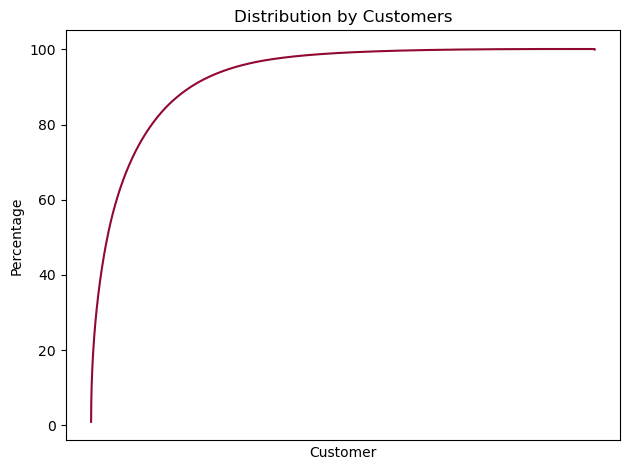

In [12]:
# plot distribution for all customers by share of revenue, note: takes a while

cumulatedplot = plt.plot(
    result['CustomerID'], 
    result["cumulatedShare"], 
    color= (145/255, 8/255, 48/255)
)

# Set axis labels and title
plt.xlabel('Customer')
plt.ylabel('Percentage')
plt.title('Distribution by Customers')

plt.tick_params(labelbottom = False, bottom = False) 
#plt.xticks(visible=False)
#plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

In [ ]:
# other plots for data understanding / presentation

### quantity per channel
sns.set_palette(palette="RdGy")
sns.displot(data=data_sample, x = "Quantity", hue = "SalesChannel", kind="kde")
plt.show()

### quantity per type and saleschannel
sns.set_theme(style="whitegrid")
sns.set_palette(palette="RdGy")

# Initialize the figure
f, ax = plt.subplots()
sns.despine(bottom=True, left=True)
# Show each observation with a scatterplot
sns.stripplot(
    data=data_sample, x="Quantity", y="Type", hue="SalesChannel",
    dodge=True, alpha=.25, zorder=1, legend=False)
# Show the conditional means
sns.pointplot(
    data=data_sample, x="Quantity", y="Type", hue="SalesChannel",
    dodge=.8 - .8 / 3, errorbar=None,
    markers="d", linestyles="none")
# Improve the legend
sns.move_legend(
    ax, loc="lower right", ncol=3, frameon=True, columnspacing=1, handletextpad=0)

### number of orders per date and channel
sns.histplot(data=df, x="OrderDate", hue = "SalesChannel", bins = 52, kde=True, color = "#852339")
plt.show()


## Feature Selection & Clustering

In [8]:
#### run for customer clustering ####

# create dataset on customer level containing behavior features: 
# Recency = time since last order, Frequency = number of orders, Monetary = sum of netRevenue
rfm = pd.DataFrame()

# timespan since most recent order per customer
#reference_time = pd.Timestamp('2023-12-31')
reference_time = datetime.today().strftime('%Y%m%d')
reference_date = pd.to_datetime(reference_time, format='%Y%m%d')
# Calculate the difference in days from the reference date
orders_top25.loc[:, 'daysSinceLastOrder'] = (reference_date - orders_top25['OrderDate']).dt.days
# Find the most recent order in weeks for each customerID
rfmrec = orders_top25.groupby('CustomerID')['daysSinceLastOrder'].min().reset_index()

# count of orders per customer
rfmfreq = orders_top25.groupby('CustomerID')['OrderNumber'].nunique().reset_index()
rfmfreq.columns = ['CustomerID', 'orderCount']

# total revenue per customer
rfmmon = orders_top25.groupby('CustomerID')['NetRevenue'].sum().reset_index()
rfmmon.columns = ['CustomerID', 'sumRevenue']

# merge features
rfm1 = pd.merge(rfmrec, rfmfreq, on='CustomerID')
rfm = pd.merge(rfm1, rfmmon, on='CustomerID')
orders_top25 =orders_top25.drop(['daysSinceLastOrder'], axis=1)

# for plotting: exclude outlier values to have better plots, tbd decide how to handle for actual clustering
#rfm.drop(rfm[rfm['orderCount'] >= 1000].index, inplace=True)
#rfm.drop(rfm[rfm['sumRevenue'] >= 10000].index, inplace=True)
#rfm.drop(rfm[rfm['sumRevenue'] <= -1000].index, inplace=True)
#rfm.describe()
print(rfm.head())
print(rfm.info())
#data_sample.info()


# customers in one cluster behave similarly considering their activities, frequencies... 
# they have a similar value for the company and importance for sales

  CustomerID  daysSinceLastOrder  orderCount    sumRevenue
0   10001245                  15         119  16977.874346
1   10001255                  15         175   4860.526178
2   10003830                  16         164   3104.510471
3   10003951                  15         400   4966.950262
4   10004155                  18         114   1982.454188
<class 'pandas.core.frame.DataFrame'>
Int64Index: 11194 entries, 0 to 11193
Data columns (total 4 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   CustomerID          11194 non-null  object 
 1   daysSinceLastOrder  11194 non-null  int64  
 2   orderCount          11194 non-null  int64  
 3   sumRevenue          11194 non-null  float64
dtypes: float64(1), int64(2), object(1)
memory usage: 437.3+ KB
None


In [6]:
##### deprecated, not needed for current run #####

#reference_time = pd.Timestamp('2023-12-31')
#reference_date = pd.to_datetime(reference_time, format='%Y%m%d')

#from datetime import datetime
#import pandas as pd
reference_time = datetime.today().strftime('%Y%m%d')
reference_date = pd.to_datetime(reference_time, format='%Y%m%d')
print(reference_date)

2024-07-07 00:00:00


In [ ]:
##### deprecated, not needed for current run #####

#check for outliers
rfm.loc[rfm['sumRevenue'] <= -1000]

In [16]:
# validate rfm calculations based on one of the entries, check if number of entries etc. is correctly calculated in rfm set
#print(rfm.info())
#rfm.head()
orders_top25.loc[orders_top25['CustomerID'] == "35284"]

,OrderNumber,Company,ArticleID,OrderDate,CustomerID,RevenueType,PricePackagingUnit,Quantity,NetRevenue,ProductGroup,ProductSubgroup,BusinessArea,Type,PostalCode,IndustryGroup,SalesChannelCategory,SalesChannel,Season,State,City
1879017,25101386,COLER,104125900,2023-01-13,35284,Gutschrift,2.962042,-1.0,2.962042,KAROSSERIE,SPIEGEL,IAM,Artikel,79108,KOO,B2B_wholesalers,B2B,Spring,Baden-Württemberg,Freiburg im Breisgau
1881899,25116407,COLER,105196941,2023-01-30,35284,Gutschrift,0.908377,-2.0,1.816754,ELEKTRIK,INSTALLATIONSMATERIAL,IAM,Artikel,79108,KOO,B2B_wholesalers,B2B,Spring,Baden-Württemberg,Freiburg im Breisgau
1884132,25122143,COLER,104243637,2023-01-17,35284,Gutschrift,3.350785,-1.0,3.350785,KRAFTÜBERTRAGUNG,KUPPLUNGSHYDRAULIK,IAM,Artikel,79108,KOO,B2B_wholesalers,B2B,Spring,Baden-Württemberg,Freiburg im Breisgau
1888760,25118366,COLER,102075669,2023-01-30,35284,Gutschrift,1.164921,-33.0,38.442408,WS-BEDARF,VERBRAUCHSMATERIALIEN,IAM,Artikel,79108,KOO,B2B_wholesalers,B2B,Spring,Baden-Württemberg,Freiburg im Breisgau
1888827,25104585,COLER,106749759,2023-01-17,35284,Gutschrift,3.471204,-1.0,3.471204,BREMSE,BELÄGE SCHEIBENBREMSE,IAM,Artikel,79108,KOO,B2B_wholesalers,B2B,Spring,Baden-Württemberg,Freiburg im Breisgau
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15909728,46953349,BUSCH,104526212,2024-06-26,35284,Rechnung,0.628272,4.0,2.513089,ZÜND-/GLÜHANLAGE,ZÜNDKERZEN,IAM,Artikel,79108,KOO,B2B_wholesalers,B2B,Summer,Baden-Württemberg,Freiburg im Breisgau
15909729,46953224,BUSCH,105616752,2024-06-26,35284,Rechnung,1.223822,2.0,2.447644,HANDWERKZEUGE,HANDWERKZEUGE WA,WA,Artikel,79108,KOO,B2B_wholesalers,B2B,Summer,Baden-Württemberg,Freiburg im Breisgau
15909730,46953264,BUSCH,105474732,2024-06-26,35284,Rechnung,4.324607,2.0,8.649215,BREMSE,BREMSSCHEIBEN,IAM,Artikel,79108,KOO,B2B_wholesalers,B2B,Summer,Baden-Württemberg,Freiburg im Breisgau
15909731,46953265,BUSCH,102574681,2024-06-26,35284,Rechnung,0.339005,2.0,0.678010,ELEKTRIK,RELAIS,IAM,Artikel,79108,KOO,B2B_wholesalers,B2B,Summer,Baden-Württemberg,Freiburg im Breisgau


In [9]:
# validate rfm calculations based on one of the entries, check if number of orders etc. is correctly calculated in rfm set
test = orders_top25.loc[orders_top25['CustomerID'] == "10001245"]

print(test["OrderNumber"].nunique())
print(test["ArticleID"].nunique())

119
2793


In [63]:
##### deprecated, not needed for current run #####

# tbd create two datasets for differentiated analyses, decide on features
# 1.: customer level: idea: rfm per customer, location/city (unique per customer?), saleschannel
# ["daysSinceLastOrder", "orderCount", "sumRevenue", BusinessArea", "IndustryGroup", "City", "SalesChannel"] = silhouette score of 0.4
# ["daysSinceLastOrder", "orderCount", "sumRevenue", "BusinessArea", "SalesChannel"] = silhouette score of 0.61
customer_data = data_sample[["CustomerID", "BusinessArea", "SalesChannel"]].drop_duplicates('CustomerID')
customer_df = pd.merge(rfm, customer_data, how='left', on='CustomerID')
print(customer_df.head())

# 2.: item level: idea: season, revenueType, quantity, netrevenue, productgroup, type...
# ["Company", "ArticleID", "RevenueType", "PricePackagingUnit", "Quantity", "NetRevenue", "BusinessArea", "Type", "IndustryGroup", "SalesChannel", "City", "Season"] = silhouette score of 0.15
# ["ArticleID", "PricePackagingUnit", "Quantity", "NetRevenue", "BusinessArea", "Type", "SalesChannel",  "Season"] = silhouette score of 0.38
# ["PricePackagingUnit", "Quantity", "NetRevenue", "BusinessArea", "Type", "SalesChannel",  "Season"] = silhouette score of 0.64
item_data = data_sample.drop(["Company", "OrderNumber", "OrderDate", "CustomerID", "ProductGroup", "ProductSubgroup", "IndustryGroup", "City", "PostalCode", "SalesChannelCategory", "State"], axis=1)
print(item_data.head())

  CustomerID  daysSinceLastOrder  orderCount  sumRevenue BusinessArea  \
0   10001245                 129           4  -16.823298          IAM   
1   10005051                 354           1    1.040576          IAM   
2   10005258                  81           3   11.130890          IAM   
3   10006364                 353           1    6.688482          IAM   
4   10007291                 104           5    9.948953          IAM   

  SalesChannel  
0        B2B2C  
1          B2B  
2        B2B2C  
3        B2B2C  
4          B2B  
          ArticleID RevenueType  PricePackagingUnit  Quantity  NetRevenue  \
7584856   102680683    Rechnung            0.178010       4.0    0.676702   
14868203  103599764    Rechnung            1.963351       1.0    1.905759   
10177177  104007803  Gutschrift            0.785340       1.0   -0.831152   
5949474   103228002    Rechnung            7.041885       1.0    7.041885   
12075583  105171948    Rechnung            1.047120       4.0    4.204188 

In [ ]:
##### deprecated, not needed for current run #####

# Scale customer-level features for clustering

# encode cf. repo file test_k-means
encoder = OneHotEncoder(sparse_output=False)
customer_encoded_features = encoder.fit_transform(customer_df[["BusinessArea", "SalesChannel"]])
customer_encoded_df = pd.DataFrame(customer_encoded_features, columns=encoder.get_feature_names_out())
# Reset the indices of all DataFrames before concatenation
customer_df_reset = customer_df.drop(["BusinessArea", "SalesChannel"], axis=1).reset_index(drop=True)
customer_encoded_df_reset = customer_encoded_df.reset_index(drop=True)
# Combine all features
customer_df_encoded = pd.concat([customer_df_reset, customer_encoded_df_reset], axis=1)
customer_df_encoded = customer_df_encoded.drop(["CustomerID"], axis=1)
#print(customer_df_encoded.info())

# scale
scaler = StandardScaler()
scaled_customer = scaler.fit_transform(customer_df_encoded)
customer_scaled = pd.DataFrame(scaled_customer, columns=customer_df_encoded.columns)
print(customer_scaled.head())

   daysSinceLastOrder  orderCount  sumRevenue
0           -0.058824   -0.171363    0.665754
1           -0.058824   -0.072432   -0.023223
2            0.000000   -0.091865   -0.123068
3           -0.058824    0.325060   -0.017172
4            0.117647   -0.180196   -0.186867
Silhouette Score for 2 clusters: 0.8788241762869875
Silhouette Score for 3 clusters: 0.8814721040100165
Silhouette Score for 4 clusters: 0.8340283700173087
Silhouette Score for 5 clusters: 0.7945965410428792
Silhouette Score for 6 clusters: 0.7248653427147868
Silhouette Score for 7 clusters: 0.7075519736820716
Silhouette Score for 8 clusters: 0.6428516843148396
Silhouette Score for 9 clusters: 0.6467515000937656
Silhouette Score for 10 clusters: 0.5866711707207821
Best top25 cluster number based on Silhouette: 3


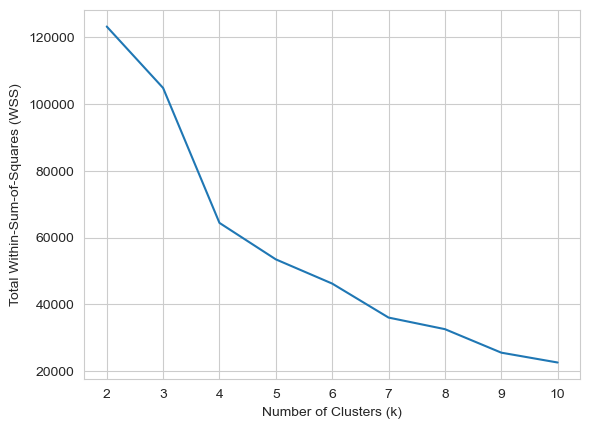

In [9]:
#### run for customer clustering ####

# adapted code for top 25%

# without categorials, score 0.88, 3 clusters
top25_df_encoded = rfm.drop(["CustomerID"], axis=1)
#print(top25_df_encoded.info())

# scale
#standard_scaler = StandardScaler()
robust_scaler = RobustScaler(quantile_range=(15, 85))
#minmax_scaler = MinMaxScaler()
#maxabs_scaler = MaxAbsScaler()

scaled_top25 = robust_scaler.fit_transform(top25_df_encoded)
top25_scaled = pd.DataFrame(scaled_top25, columns=top25_df_encoded.columns)
#top25_scaled["CustomerID"] = rfm["CustomerID"]
print(top25_scaled.head())

# apply K-Means Clustering with Silhouette Score
top25_tot_withinss = []
top25_cluster_scores = []
ks = list(range(2, 11))
for k in ks:
    kmeans = KMeans(n_clusters=k, random_state=45, n_init="auto") #test MiniBatchKMeans 
    clusters = kmeans.fit_predict(top25_scaled)
    score = silhouette_score(top25_scaled, clusters)
    top25_cluster_scores.append((k, score))
    print(f"Silhouette Score for {k} clusters: {score}")
    top25_tot_withinss.append(kmeans.inertia_)
    

# Get best cluster number
top25_best_cluster = max(top25_cluster_scores, key=lambda x: x[1])[0]
print(f"Best top25 cluster number based on Silhouette: {top25_best_cluster}")

# plot elbow graph
top25_withinss_df = pd.DataFrame({'k': ks, 'tot_withinss': top25_tot_withinss})
sns.set_style("whitegrid")
sns.lineplot(data=top25_withinss_df, x='k', y='tot_withinss')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Total Within-Sum-of-Squares (WSS)')
plt.show()


In [26]:
top25_scaled.head()

,daysSinceLastOrder,orderCount,sumRevenue,CustomerID,cluster
0,-0.142857,-0.237762,0.664636,10001245,0
1,0.000000,-0.101399,-0.071380,10001255,0
2,0.357143,-0.129371,-0.165845,10003830,0
3,0.000000,0.541958,-0.078419,10003951,0
4,-0.071429,-0.216783,-0.204283,10004155,0


In [10]:
#### run for customer clustering ####

# visualization top25

#top25_best_cluster = 3
customer_k_means_optimum = KMeans(n_clusters=top25_best_cluster, random_state=45, n_init="auto")
customer_k_means_optimum.fit_predict(top25_scaled[["daysSinceLastOrder", "orderCount", "sumRevenue"]])
top25_scaled['cluster'] = customer_k_means_optimum.labels_
top25_scaled["CustomerID"] = rfm["CustomerID"]
# Create a dictionary to hold the subset DataFrames
cluster_subsets = {}
# Loop through each unique cluster label and create a subset DataFrame
for cluster_num in top25_scaled['cluster'].unique():
    cluster_subsets[cluster_num] = top25_scaled[top25_scaled['cluster'] == cluster_num]   


In [12]:
#top25_scaled.head()

clusterassignment = top25_scaled['cluster'].value_counts()
clusterassignment


1    10672
0      489
2       33
Name: cluster, dtype: int64

In [15]:
test = cluster_subsets[2].sort_values("sumRevenue", ascending=False)
test.head()
# outliers CustomerID: 151238, 9883351, 10465952, 35284 

,daysSinceLastOrder,orderCount,sumRevenue,cluster,CustomerID
1830,-0.058824,0.812649,47.765144,2,151238
11055,-0.058824,0.130731,46.100250,2,9883351
3677,-0.058824,83.201131,32.127435,2,35284
660,-0.235294,43.519124,11.599258,2,10465952
9178,-0.058824,36.334246,9.795393,2,73845


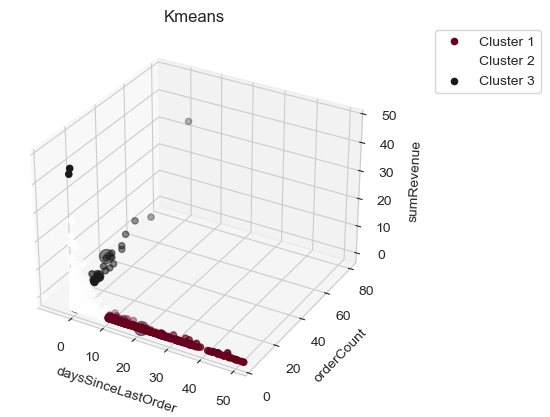

In [13]:
#### run for customer clustering ####

# plot top 25%
kplot = plt.axes(projection='3d')
xline = np.linspace(0, 15, 1000)
yline = np.linspace(0, 15, 1000)
zline = np.linspace(0, 15, 1000)
#import matplotlib as mpl
colors = mpl.colormaps['RdGy'].resampled(top25_best_cluster)

for i in range(top25_best_cluster):
  subset_plot = cluster_subsets[i]
  kplot.scatter3D(subset_plot["daysSinceLastOrder"], subset_plot["orderCount"], subset_plot["sumRevenue"], color = colors(i), label = f'Cluster {i+1}')
  kplot.scatter3D(customer_k_means_optimum.cluster_centers_[i,0], customer_k_means_optimum.cluster_centers_[i,1],customer_k_means_optimum.cluster_centers_[i,2], color = colors(i),edgecolors='black', s = 100, alpha = 0.5)
plt.xlim(top25_scaled['daysSinceLastOrder'].min(), top25_scaled['daysSinceLastOrder'].max())
plt.ylim(top25_scaled['orderCount'].min(), top25_scaled['orderCount'].max())
plt.legend(bbox_to_anchor=(1.15, 1), loc='upper left', borderaxespad=0.)
set_xlabel = kplot.set_xlabel('daysSinceLastOrder')
set_ylabel = kplot.set_ylabel('orderCount')
set_zlabel = kplot.set_zlabel('sumRevenue')
plt.title("Kmeans")
plt.show()

In [ ]:
##### deprecated, not needed for current run #####

# apply K-Means Clustering with Silhouette Score on original customer dataset
customer_tot_withinss = []
customer_cluster_scores = []
ks = list(range(2, 16))
for k in ks:
    kmeans = KMeans(n_clusters=k, random_state=42)
    clusters = kmeans.fit_predict(customer_scaled)
    score = silhouette_score(customer_scaled, clusters)
    customer_cluster_scores.append((k, score))
    print(f"Silhouette Score for {k} clusters: {score}")
    customer_tot_withinss.append(kmeans.inertia_)

# Get best cluster number
customer_best_cluster = max(customer_cluster_scores, key=lambda x: x[1])[0]
print(f"Best customer cluster number based on Silhouette: {customer_best_cluster}")

# plot elbow graph
customer_withinss_df = pd.DataFrame({'k': ks, 'tot_withinss': customer_tot_withinss})
sns.set_style("whitegrid")
sns.lineplot(data=customer_withinss_df, x='k', y='tot_withinss')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Total Within-Sum-of-Squares (WSS)')
plt.show()


In [ ]:
##### deprecated, not needed for current run #####

# visualization on original customer dataset

#customer_best_cluster = 4
customer_k_means_optimum = KMeans(n_clusters=customer_best_cluster, random_state=42)
customer_k_means_optimum.fit_predict(customer_scaled)
customer_scaled['cluster'] = customer_k_means_optimum.labels_
# Create a dictionary to hold the subset DataFrames
cluster_subsets = {}
# Loop through each unique cluster label and create a subset DataFrame
for cluster_num in customer_scaled['cluster'].unique():
    cluster_subsets[cluster_num] = customer_scaled[customer_scaled['cluster'] == cluster_num]   

# plot
kplot = plt.axes(projection='3d')
xline = np.linspace(0, 15, 1000)
yline = np.linspace(0, 15, 1000)
zline = np.linspace(0, 15, 1000)
colors = mpl.colormaps['RdGy'].resampled(customer_best_cluster)

for i in range(customer_best_cluster):
  subset_plot = cluster_subsets[i]
  kplot.scatter3D(subset_plot["orderCount"], subset_plot["daysSinceLastOrder"], subset_plot["sumRevenue"], color = colors(i), label = f'Cluster {i+1}')
  kplot.scatter3D(customer_k_means_optimum.cluster_centers_[i,0], customer_k_means_optimum.cluster_centers_[i,1],customer_k_means_optimum.cluster_centers_[i,2], color = colors(i),edgecolors='black', s = 100, alpha = 0.5)
plt.xlim(customer_scaled['orderCount'].min(), customer_scaled['orderCount'].max())
plt.ylim(customer_scaled['daysSinceLastOrder'].min(), customer_scaled['daysSinceLastOrder'].max())
plt.legend(bbox_to_anchor=(1.15, 1), loc='upper left', borderaxespad=0.)
set_xlabel = kplot.set_xlabel('orderCount')
set_ylabel = kplot.set_ylabel('daysSinceLastOrder')
set_zlabel = kplot.set_zlabel('sumRevenue')
plt.title("Kmeans")
plt.show()

In [ ]:
##### deprecated, not needed for current run #####

test = customer_k_means_optimum.cluster_centers_
test[:10]

In [ ]:
##### deprecated, not needed for current run #####

item_data = data_sample[["ArticleID", "NetRevenue", "PricePackagingUnit", "Quantity"]]
print(item_data.info())
print(item_data["ArticleID"].nunique())

itemfeatures = pd.DataFrame()

rev = item_data.groupby('ArticleID')['NetRevenue'].sum().reset_index()
rev.columns = ['ArticleID', 'NetRevenue']
price = item_data.groupby('ArticleID')['PricePackagingUnit'].sum().reset_index()
price.columns = ['ArticleID', 'PricePackagingUnit']
quant = item_data.groupby('ArticleID')['Quantity'].sum().reset_index()
quant.columns = ['ArticleID', 'Quantity']
freq = item_data['ArticleID'].value_counts().reset_index()
freq.columns = ['ArticleID', 'OrderCount']

#print(freq.head())
# merge features
itemfeatures1 = pd.merge(rev, price, on='ArticleID')
itemfeatures2 = pd.merge(itemfeatures1, quant, on='ArticleID')
itemfeatures = pd.merge(itemfeatures2, freq, on='ArticleID')
itemfeatures =itemfeatures.drop(['ArticleID', 'PricePackagingUnit'], axis=1)
print(itemfeatures.head())
data_sample.loc[data_sample['ArticleID'] == 106060360]

In [ ]:
##### deprecated, not needed for current run #####

# item features

robust_scaler = RobustScaler(quantile_range=(15, 85))
#minmax_scaler = MinMaxScaler()
#maxabs_scaler = MaxAbsScaler()

scaled_item = robust_scaler.fit_transform(itemfeatures)
item_scaled = pd.DataFrame(scaled_item, columns=itemfeatures.columns)
print(item_scaled.head())


# apply K-Means Clustering with Silhouette Score
item_tot_withinss = []
item_cluster_scores = []
ks = list(range(2, 11))
for k in ks:
    kmeans = KMeans(n_clusters=k, random_state=43, n_init="auto")
    clusters = kmeans.fit_predict(item_scaled)
    score = silhouette_score(item_scaled, clusters)
    item_cluster_scores.append((k, score))
    print(f"Silhouette Score for {k} clusters: {score}")
    item_tot_withinss.append(kmeans.inertia_)
    
# Get best cluster number
item_best_cluster = max(item_cluster_scores, key=lambda x: x[1])[0]
print(f"Best item cluster number based on Silhouette: {item_best_cluster}")
    
item_withinss_df = pd.DataFrame({'k': ks, 'tot_withinss': item_tot_withinss})
sns.set_style("whitegrid")
sns.lineplot(data=item_withinss_df, x='k', y='tot_withinss')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Total Within-Sum-of-Squares (WSS)')
plt.show()

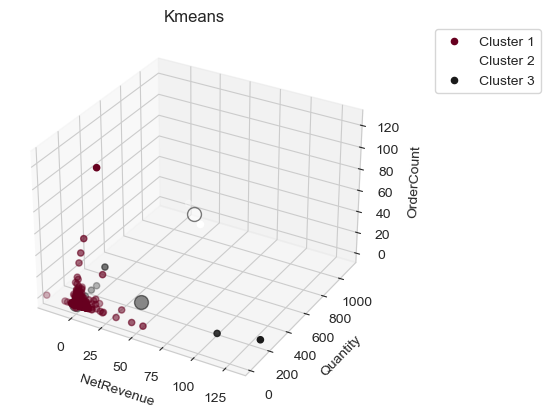

In [79]:
##### deprecated, not needed for current run #####

# visualization item features

item_best_cluster = 3
item_k_means_optimum = KMeans(n_clusters=item_best_cluster, random_state=43, n_init="auto")
item_k_means_optimum.fit_predict(item_scaled)
item_scaled['cluster'] = item_k_means_optimum.labels_
# Create a dictionary to hold the subset DataFrames
cluster_subsets = {}
# Loop through each unique cluster label and create a subset DataFrame
for cluster_num in item_scaled['cluster'].unique():
    cluster_subsets[cluster_num] = item_scaled[item_scaled['cluster'] == cluster_num]   

# plot
kplot = plt.axes(projection='3d')
xline = np.linspace(0, 15, 1000)
yline = np.linspace(0, 15, 1000)
zline = np.linspace(0, 15, 1000)
colors = mpl.colormaps['RdGy'].resampled(item_best_cluster)

for i in range(item_best_cluster):
  subset_plot = cluster_subsets[i]
  kplot.scatter3D(subset_plot["NetRevenue"], subset_plot["Quantity"], subset_plot["OrderCount"], color = colors(i), label = f'Cluster {i+1}')
  kplot.scatter3D(item_k_means_optimum.cluster_centers_[i,0], item_k_means_optimum.cluster_centers_[i,1],item_k_means_optimum.cluster_centers_[i,2], color = colors(i),edgecolors='black', s = 100, alpha = 0.5)
plt.xlim(item_scaled['NetRevenue'].min(), item_scaled['NetRevenue'].max())
plt.ylim(item_scaled['Quantity'].min(), item_scaled['Quantity'].max())
plt.legend(bbox_to_anchor=(1.15, 1), loc='upper left', borderaxespad=0.)
set_xlabel = kplot.set_xlabel('NetRevenue')
set_ylabel = kplot.set_ylabel('Quantity')
set_zlabel = kplot.set_zlabel('OrderCount')
plt.title("Kmeans")
plt.show()

In [ ]:
##### deprecated, not needed for current run #####

# Scale item features for clustering

# encode cf. repo file test_k-means
encoder = OneHotEncoder(sparse_output=False)
item_encoded_features = encoder.fit_transform(item_data[['SalesChannel', 'Type', 'BusinessArea', 'Season']])
item_encoded_df = pd.DataFrame(item_encoded_features, columns=encoder.get_feature_names_out())
# Reset the indices of all DataFrames before concatenation
item_df_reset = item_data.drop(['SalesChannel', 'Type', 'BusinessArea', 'RevenueType', 'Season'], axis=1).reset_index(drop=True)
item_encoded_df_reset = item_encoded_df.reset_index(drop=True)
# Combine all features
item_df_encoded = pd.concat([item_df_reset, item_encoded_df_reset], axis=1)
#print(item_df_encoded.info())

# scale
scaler = StandardScaler()
scaled_item = scaler.fit_transform(item_df_encoded)
item_scaled = pd.DataFrame(scaled_item, columns=item_df_encoded.columns)
print(item_df_encoded.head())

In [ ]:
##### deprecated, not needed for current run #####

# apply K-Means Clustering with Silhouette Score
item_tot_withinss = []
item_cluster_scores = []
ks = list(range(2, 21))
for k in ks:
    kmeans = KMeans(n_clusters=k, random_state=42)
    clusters = kmeans.fit_predict(item_scaled)
    score = silhouette_score(item_scaled, clusters)
    item_cluster_scores.append((k, score))
    print(f"Silhouette Score for {k} clusters: {score}")
    item_tot_withinss.append(kmeans.inertia_)
    
# Get best cluster number
item_best_cluster = max(item_cluster_scores, key=lambda x: x[1])[0]
print(f"Best item cluster number based on Silhouette: {item_best_cluster}")
    
item_withinss_df = pd.DataFrame({'k': ks, 'tot_withinss': item_tot_withinss})
sns.set_style("whitegrid")
sns.lineplot(data=item_withinss_df, x='k', y='tot_withinss')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Total Within-Sum-of-Squares (WSS)')
plt.show()

In [ ]:
##### deprecated, not needed for current run #####

# visualization
# tbd use PCA to include all features?

#customer_best_cluster = 10
item_k_means_optimum = KMeans(n_clusters=item_best_cluster, random_state=42)
item_k_means_optimum.fit_predict(item_scaled)
item_scaled['cluster'] = item_k_means_optimum.labels_
# Create a dictionary to hold the subset DataFrames
cluster_subsets = {}
# Loop through each unique cluster label and create a subset DataFrame
for cluster_num in item_scaled['cluster'].unique():
    cluster_subsets[cluster_num] = item_scaled[item_scaled['cluster'] == cluster_num]   

# plot
kplot = plt.axes(projection='3d')
xline = np.linspace(0, 15, 1000)
yline = np.linspace(0, 15, 1000)
zline = np.linspace(0, 15, 1000)
colors = mpl.colormaps['RdGy'].resampled(item_best_cluster)

for i in range(item_best_cluster):
  subset_plot = cluster_subsets[i]
  kplot.scatter3D(subset_plot["PricePackagingUnit"], subset_plot["Quantity"], subset_plot["Quantity"], color = colors(i), label = f'Cluster {i+1}')
  kplot.scatter3D(item_k_means_optimum.cluster_centers_[i,0], item_k_means_optimum.cluster_centers_[i,1],item_k_means_optimum.cluster_centers_[i,2], color = colors(i),edgecolors='black', s = 100, alpha = 0.5)
plt.xlim(item_scaled['PricePackagingUnit'].min(), item_scaled['PricePackagingUnit'].max())
plt.ylim(item_scaled['NetRevenue'].min(), item_scaled['NetRevenue'].max())
plt.legend(bbox_to_anchor=(1.15, 1), loc='upper left', borderaxespad=0.)
set_xlabel = kplot.set_xlabel('PricePackagingUnit')
set_ylabel = kplot.set_ylabel('NetRevenue')
set_zlabel = kplot.set_zlabel('Quantity')
plt.title("Kmeans")
plt.show()

In [39]:
##### deprecated, not needed for current run #####

# reduce dimensionality of rfm features
# tbd decide whether to use that for clustering or plotting
pca = PCA(n_components=15)
pca.fit(item_scaled)
print(pca.explained_variance_ratio_)

# correlation matrix of rfm features
matrix = item_scaled.corr()
print("Correlation matrix is : ")
print(matrix)

[0.11122609 0.08642162 0.06701703 0.06172303 0.05637545 0.05598893
 0.05420709 0.04889706 0.0460519  0.04512186 0.04331107 0.04171642
 0.04165334 0.04132398 0.04120308]


In [ ]:
##### deprecated, not needed for current run #####

# tbd test different parameters for k-means
# https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_digits.html#sphx-glr-auto-examples-cluster-plot-kmeans-digits-py

# option 1
kmeans = KMeans(init="k-means++", n_clusters=n_digits, n_init=4, random_state=0)
# option 2
kmeans = KMeans(init="random", n_clusters=n_digits, n_init=4, random_state=0)
# option 3
pca = PCA(n_components=n_digits).fit(data)
kmeans = KMeans(init=pca.components_, n_clusters=n_digits, n_init=1)

In [19]:
##### deprecated, not needed for current run #####

# original code from repo, adapted to generic function for subsets

def encodeDataset(column, value):
    df_small = data_sample
    df_small['CustomerID'] = df_small['CustomerID'].astype(int)

# choose subset to focus on (saleschannel, company, season)
    df_small = df_small[df_small[column] == value]

# High cardinality features
    high_card_cols = ['City', 'ProductGroup', 'ProductSubgroup', 'PostalCode']
    high_card_data = df_small[high_card_cols].astype(str).values.tolist()
    hasher = FeatureHasher(n_features=10, input_type='string')
    hashed_features = hasher.fit_transform(high_card_data)

# Convert hashed features to a DataFrame
    hashed_features_df = pd.DataFrame(hashed_features.toarray(), columns=[f'hash_{i}' for i in range(10)])

# One-hot encoding for other categorical variables
    encoder = OneHotEncoder(sparse_output=False)
    encoded_features = encoder.fit_transform(df_small[['SalesChannel', 'IndustryGroup', 'Type', 'BusinessArea', 'Company', 'RevenueType']])
    encoded_df = pd.DataFrame(encoded_features, columns=encoder.get_feature_names_out())

# Reset the indices of all DataFrames before concatenation
    df_small_reset = df_small.drop(['City', 'ProductGroup', 'ProductSubgroup', 'PostalCode', 'SalesChannel', 'IndustryGroup', 'Type', 'BusinessArea', 'Company', 'RevenueType'], axis=1).reset_index(drop=True)
    hashed_features_df_reset = hashed_features_df.reset_index(drop=True)
    encoded_df_reset = encoded_df.reset_index(drop=True)

# Combine all features
    df2 = pd.concat([df_small_reset, hashed_features_df_reset, encoded_df_reset], axis=1)
    #print(df2.info())
    return df2

In [ ]:
##### deprecated, not needed for current run #####

# correlation analysis for subset-wise differentiation

# correlation matrix
dataset = encodeDataset("SalesChannel", "B2B") # choose SalesChannel, Company etc. for differentiation
matrix_encoded = dataset.corr()
print("Correlation matrix is : ")
print(matrix_encoded)

# insights: e.g. Company = Hennig : only Type_Artikel, 
# Company = AAG, Type_Artikel& Service,
# SalesChannel = B2B: correlation quantity & coler, netrevenue & aag

## Predictions

In [ ]:
### just some initial testing for predictions on item level
# not done yet

#data_sample.info()
#data_sample.head(5)

# keep only relevant features = ArticleID, orderDate
# for testing Pfand was removed, huge outliers
df1 = df[df.ProductGroup != "PFAND"]
#df1.loc[df1["ProductGroup"] == "PFAND"]

predData=df1[["ArticleID", "OrderDate", "Quantity"]]
print(predData.head())

# fill NaN quantities with 1 (what is the original value for that?! tbd)
predDatafilled = predData.fillna(value = 1)
predDatafilled.info()


# USE THIS ONE, only for one article
itemlevelpred = predDatafilled.loc[predDatafilled["ArticleID"] == 112035138]
itemlevelpred = itemlevelpred.drop("ArticleID", axis = 1)

itemlevelpred = itemlevelpred.sort_values(by="OrderDate")
itemlevelpred = itemlevelpred.groupby('OrderDate')['Quantity'].sum().reset_index()
itemlevelpred = itemlevelpred.groupby([pd.Grouper(key='OrderDate', freq='W-MON', label='left')])['Quantity'].sum().reset_index().sort_values('OrderDate')
#print(df)
itemlevelpred.set_index('OrderDate', inplace=True)

print(itemlevelpred.head())
print(itemlevelpred.info())

plt.plot(itemlevelpred.index, itemlevelpred['Quantity'])
plt.xlabel('Time')
plt.ylabel('Quantity')
plt.xticks(rotation = 45)
plt.title('Time Series Data')
plt.show()

ADF Statistic: -5.169420709426526
p-value: 1.0147967559693962e-05
	1%: -3.568
	5%: -2.921
	10%: -2.599


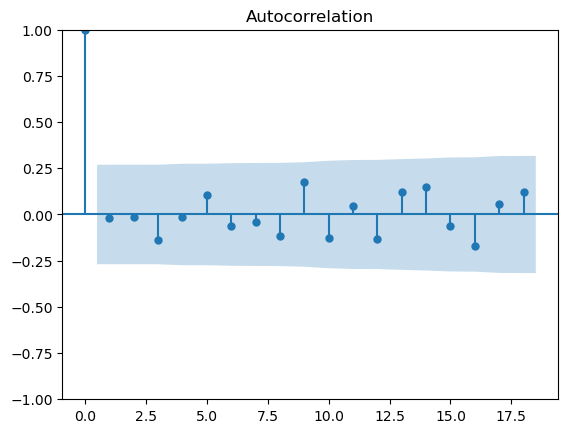

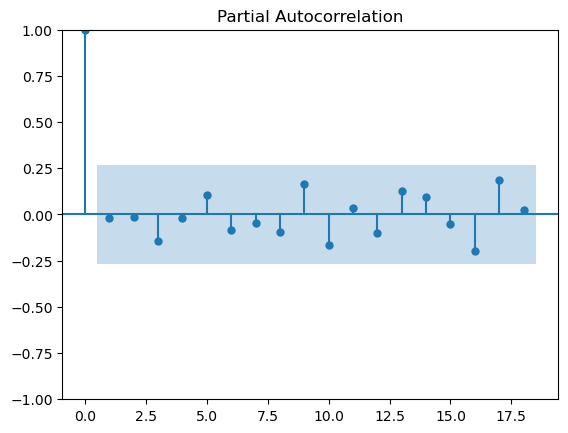

In [49]:
# USE THIS ONE for fitting on different functions

# https://www.timescale.com/blog/how-to-work-with-time-series-in-python/
    
# test for stationarity
from statsmodels.tsa.stattools import adfuller
# Assuming 'data' is the time series data
result = adfuller(itemlevelpred["Quantity"])
print('ADF Statistic:', result[0])
print('p-value:', result[1])
for key, value in result[4].items():
 print('\t%s: %.3f' % (key, value))
# p-value <= 0.05: Reject the null hypothesis (H0), the data does not have a unit root and is stationary

# test for autocorrelation
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
# Assuming 'data' is the time series data
plot_acf(itemlevelpred["Quantity"])
plot_pacf(itemlevelpred["Quantity"])
plt.show()
# ACF are within 95% confidence interval = data doesn’t have any autocorrelation
# ACF outside of interval = autocorrelation
# here: no autocorrelation??

#tbd 
#from statsmodels.tsa.seasonal import seasonal_decompose
#decompose_result = seasonal_decompose(itemlevelpred)

In [ ]:
# USE THIS ONE item level
# tbd https://medium.com/analytics-vidhya/python-code-on-holt-winters-forecasting-3843808a9873

# single exponential smoothing
from statsmodels.tsa.holtwinters import SimpleExpSmoothing   
itemlevelpred["HWES1"] = SimpleExpSmoothing(itemlevelpred["Quantity"]).fit().fittedvalues
itemlevelpred[["Quantity","HWES1"]].plot(title="Holt Winters Single Exponential Smoothing")


'''# double and triple exponential smoothing
from statsmodels.tsa.holtwinters import ExponentialSmoothing
itemlevelpred["HWES3_ADD"] = ExponentialSmoothing(itemlevelpred["Quantity"],trend="add").fit().fittedvalues
itemlevelpred["HWES3_MUL"] = ExponentialSmoothing(itemlevelpred["Quantity"],trend="mul").fit().fittedvalues
itemlevelpred[["Quantity","HWES3_ADD", "HWES3_MUL"]].plot(title="Holt Winters Triple Exponential Smoothing: Additive and Multiplicative Seasonality")


# https://machinelearningmastery.com/time-series-forecasting-methods-in-python-cheat-sheet/

# ARIMA
from statsmodels.tsa.arima.model import ARIMA
# fit model
model = ARIMA(itemlevelpred["Quantity"], order=(1, 1, 1))
itemlevelpred["ARIMA"] = model_fit = model.fit().fittedvalues
itemlevelpred[["Quantity","ARIMA"]].plot(title="ARIMA")
# make prediction tbd
#yhat = model_fit.predict(len(itemlevelpred), len(itemlevelpred), typ='levels')
#print(yhat)'''

In [ ]:
#### tbd Predictions on customer Level ####

# idea: take cluster assignments from customer clustering
# within each cluster, fit model to NetRevenue data (2022,2023)
# predict future NetRevenue per CustomerID (2024)